<a href="https://colab.research.google.com/github/roy029/beginner/blob/main/Bento_finalreport_%E4%BF%9D%E5%AD%98%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#【レポート課題】お弁当の需要予測

とある会社のカフェフロアで販売されているお弁当の販売数を予測するモデルを作成していただきます。


*   売れ残りのお弁当から漂う哀愁は、環境にも、そしてお弁当屋さんの懐にも優しくありません。
*   売り切れは、お弁当屋さんにとっては機会損失、カフェフロアまで来た社員にとっては時間損失となります。


今回は、曜日やメニュー等の複数の変数から最適なお弁当の量を推測していただき、お弁当屋さんと、その利用者、そして環境に貢献していただきます。


## 1. 準備（データ）をダウンロード

倉光研のGithubからどうぞ



*   bento_train.csv - 訓練データ
*   bento_test.csv - 検証データ





In [ ]:
# まず、訓練データとテストデータをダウンロードします
! wget http://kuramitsulab.github.io/data/bento_train.csv
! wget http://kuramitsulab.github.io/data/bento_test.csv

--2020-08-03 05:34:11--  http://kuramitsulab.github.io/data/bento_train.csv
Resolving kuramitsulab.github.io (kuramitsulab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to kuramitsulab.github.io (kuramitsulab.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14821 (14K) [text/csv]
Saving to: ‘bento_train.csv.1’

bento_train.csv.1   100%[===================>]  14.47K  --.-KB/s    in 0.01s   

2020-08-03 05:34:11 (1.15 MB/s) - ‘bento_train.csv.1’ saved [14821/14821]

--2020-08-03 05:34:13--  http://kuramitsulab.github.io/data/bento_test.csv
Resolving kuramitsulab.github.io (kuramitsulab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to kuramitsulab.github.io (kuramitsulab.github.io)|185.199.111.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2900 (2.8K) [text/csv]
Saving to: ‘bento_test.csv.1’

bento_test.csv.1    100%[===================>]   2

## データの確認

データの内容を確認します。


In [ ]:
import pandas as pd


In [ ]:
bento = pd.read_csv('bento_train.csv')
bento.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


## データの説明

y が目的変数です。

それ以外は、自由に選択して説明変数にして、モデルを構築してみてください。


```csv
ヘッダ名称	データ型	説明
datetid	datetime	インデックスとして使用する日付（yyyy-m-d）
y	int	販売数（目的変数）
week	char	曜日（月～金）
soldout	boolean	完売フラグ（0:完売せず、1:完売）
name	varchar	メインメニュー
kcal	int	おかずのカロリー（kcal）欠損有り
remarks	varchar	特記事項
event	varchar	13時開始お弁当持ち込み可の社内イベント
payday	boolean	給料日フラグ（1:給料日）
weather	varchar	天気
precipitation	float	降水量。ない場合は "--"
temperature	float	気温
```


# レポート解答

ここから、訓練データを用いて、各自、モデルの構築をおこなって、
検証用のデータで正確さ(score)を求めてみましょう。
できるだけ高い正確さの高いモデルを作るように頑張りましょう。

ヒント：

1.   売り上げ数と説明変数との関係を簡単な基礎分析で見ていきます。
2.   欠損値補間します
3.   お弁当の売り上げ分布の確認します
4.   目的変数と説明変数（数値変数）との散布図の確認します

ヒント２：

1.   単回帰でモデルの検討をしてみる
2.   Random Forestを用いて単回帰モデルの結果を修正するモデルも作成
3.   他の手法も検討してみよう

提出は、Colab 共有でどうぞ！！　


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns


In [ ]:
train = pd.read_csv('bento_train.csv')
test = pd.read_csv('bento_test.csv')

In [ ]:
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [ ]:
test.head()

,datetime,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2014-10-1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1


## 欠損値の確認

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

datetime           0
y                  0
week               0
soldout            0
name               0
kcal              41
remarks          186
event            193
payday           197
weather            0
precipitation      0
temperature        0
dtype: int64
datetime          0
week              0
soldout           0
name              0
kcal              4
remarks          33
event            37
payday           38
weather           0
precipitation     0
temperature       0
dtype: int64


## 不要データの削除

In [ ]:
train = train.drop(['remarks', 'event', 'payday', 'precipitation'], axis = 1)

In [ ]:
test = test.drop(['remarks', 'event', 'payday', 'precipitation'], axis = 1)

In [ ]:
train.head()

,datetime,y,week,soldout,name,kcal,weather,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,快晴,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,快晴,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,快晴,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,快晴,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,快晴,16.1


In [ ]:
test.head()

,datetime,week,soldout,name,kcal,weather,temperature
0,2014-10-1,水,1,メンチカツ,420.0,雨,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,曇,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,晴れ,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,雨,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,晴れ,22.1


## 欠損値の補完(中央値の利用)

In [ ]:
train['kcal'] = train['kcal'].fillna(train['kcal'].median())
test['kcal'] = test['kcal'].fillna(test['kcal'].median())

In [ ]:
train.head()

,datetime,y,week,soldout,name,kcal,weather,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,408.5,快晴,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,408.5,快晴,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,408.5,快晴,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,408.5,快晴,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,408.5,快晴,16.1


In [ ]:
test.head()

,datetime,week,soldout,name,kcal,weather,temperature
0,2014-10-1,水,1,メンチカツ,420.0,雨,20.2
1,2014-10-2,木,0,バーベキューチキン,415.0,曇,23.9
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,晴れ,28.7
3,2014-10-6,月,1,麻婆春雨,400.0,雨,21.5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,晴れ,22.1


In [ ]:
#補完されているかの確認
print(train.isnull().sum())
print(test.isnull().sum())

datetime       0
y              0
week           0
soldout        0
name           0
kcal           0
weather        0
temperature    0
dtype: int64
datetime       0
week           0
soldout        0
name           0
kcal           0
weather        0
temperature    0
dtype: int64


##目的変数を選ぶ

In [ ]:
#温度を説明変数とする
X_train = train['temperature']
#売上個数を目的変数とする
y_train = train['y']
#予測用データ
X_test = test['temperature']

X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
X_train[:5]

array([[19.8],
       [17. ],
       [15.5],
       [15.2],
       [16.1]])

##モデルの準備

In [ ]:
from sklearn.linear_model import LinearRegression as LR

In [ ]:
#モデルの定義と作成
model = LR()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 単回帰でモデルを検討する

In [ ]:
model.coef_ #傾き

array([-2.5023821])

In [ ]:
model.intercept_ #切片

134.79948383749922

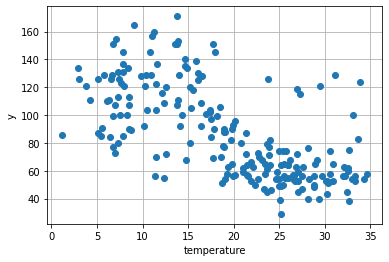

In [ ]:
#販売数と温度の関係を調べる
plt.plot(train['temperature'], train['y'], 'o')
plt.ylabel('y')
plt.xlabel('temperature')
plt.grid(True)

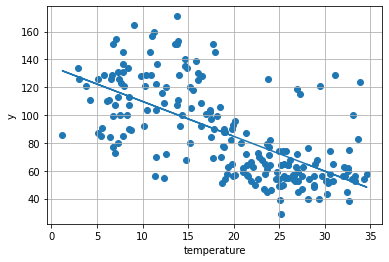

In [ ]:
plt.scatter(X_train, y_train)
plt.xlabel('temperature')
plt.ylabel('y')

plt.plot(X_train, model.predict(X_train))
plt.grid(True)

In [ ]:
model.score(X_train, y_train) #検証

0.4294602815194137

In [ ]:
pred = model.predict(X_test)
print(pred)

[ 84.25136537  74.99255159  62.9811175   80.99826864  79.49683938
  76.49398085  78.49588653  69.48731097  67.73564349  95.76232304
  88.25517673  77.24469548  74.99255159  84.25136537  96.01256125
  98.01446693  88.00493852  77.99541011  87.00398568  85.75279463
  85.75279463  87.75470031  87.5044621   94.7613702   86.75374747
  84.50160358  81.74898327  98.01446693  98.76518156  86.00303284
  95.26184662  99.01541977  94.51113199  97.51399051 108.52447176
  97.51399051 106.27232787 111.7775685   97.01351409  96.51303767]


##ランダムフォレストを用いて単回帰モデルの結果を修正するモデルを作成する

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
dat = pd.concat([train,test],sort=True).reset_index(drop=True)
dat.index = pd.to_datetime(dat["datetime"])
#dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

#dat["days"] = dat.index
days = dat.iloc[:,-1]

In [ ]:
print(dat)

       datetime   kcal          name  soldout  ...  weather week      y  days
0    2013-11-18  408.5      厚切りイカフライ        0  ...       快晴    月   90.0     0
1    2013-11-19  408.5       手作りヒレカツ        1  ...       快晴    火  101.0     1
2    2013-11-20  408.5    白身魚唐揚げ野菜あん        0  ...       快晴    水  118.0     2
3    2013-11-21  408.5        若鶏ピリ辛焼        1  ...       快晴    木  120.0     3
4    2013-11-22  408.5      ビッグメンチカツ        1  ...       快晴    金  130.0     4
..          ...    ...           ...      ...  ...      ...  ...    ...   ...
242  2014-11-21  420.0         ロコモコ丼        0  ...       快晴    金    NaN   242
243  2014-11-25  460.0   なすと挽肉のはさみ揚げ        1  ...        雨    火    NaN   243
244  2014-11-26  415.0       鶏肉の治部煮風        1  ...        雨    水    NaN   244
245  2014-11-27  420.0           牛丼風        0  ...       快晴    木    NaN   245
246  2014-11-28  416.0  鶏肉のスイートチリソース        0  ...        曇    金    NaN   246

[247 rows x 9 columns]


In [ ]:
train["days"] = days

In [ ]:
train['days'] = train['days'].fillna(train['days'].median())

In [ ]:
train.head()

,datetime,y,week,soldout,name,kcal,weather,temperature,days
0,2013-11-18,90,月,0,厚切りイカフライ,408.5,快晴,19.8,90.0
1,2013-11-19,101,火,1,手作りヒレカツ,408.5,快晴,17.0,101.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,408.5,快晴,15.5,118.0
3,2013-11-21,120,木,1,若鶏ピリ辛焼,408.5,快晴,15.2,120.0
4,2013-11-22,130,金,1,ビッグメンチカツ,408.5,快晴,16.1,130.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor

#ランダムフォレストと勾配ブースティングのパラメータ設定
models = {
    'RandomForest':RF(random_state=0),
    'GradientBoost':GradientBoostingRegressor(random_state=0)
}

y_test = pred
#モデル構築
scores = {}
for model_name, model in models.items():
  model.fit(X_train,y_train)
  scores[(model_name,'train_score')] = model.score(X_train, y_train)
  scores[(model_name,'test_score')] = model.score(X_test, y_test)

#結果を表示
pd.Series(scores).unstack()

In [ ]:
def learning(train,y_train):
    model2 = RF(n_estimators=100,max_depth=4,random_state=777)
    pred = model.predict(train["days"].values.reshape(-1,1))
    #print(pred)
    pred_sub = y_train - pred
    #print(pred_sub)
    model2.fit(train.iloc[:, train.columns.str.match("y")],pred_sub)
    return model2

In [ ]:
print(train.iloc[:, ~train.columns.str.match("y")])

       datetime week  soldout          name   kcal weather  temperature   days
0    2013-11-18    月        0      厚切りイカフライ  408.5      快晴         19.8   90.0
1    2013-11-19    火        1       手作りヒレカツ  408.5      快晴         17.0  101.0
2    2013-11-20    水        0    白身魚唐揚げ野菜あん  408.5      快晴         15.5  118.0
3    2013-11-21    木        1        若鶏ピリ辛焼  408.5      快晴         15.2  120.0
4    2013-11-22    金        1      ビッグメンチカツ  408.5      快晴         16.1  130.0
..          ...  ...      ...           ...    ...     ...          ...    ...
202   2014-9-24    水        1   白身魚のマスタード焼き  408.0       曇         24.8   59.0
203   2014-9-25    木        0       牛カルビ焼き肉  394.0       曇         25.4   50.0
204   2014-9-26    金        0      ランチビュッフェ  408.5      晴れ         27.1   45.0
205   2014-9-29    月        1      豚肉と玉子の炒め  404.0      快晴         26.6   56.0
206   2014-9-30    火        0  鶏肉とカシューナッツ炒め  398.0      快晴         28.1   40.0

[207 rows x 8 columns]


In [ ]:
model.score(X_train, y_train) #検証（１に近いほど説明変数を用いて目的変数を表示できていることを表す）

0.7980590956007098

In [ ]:
pred = model.predict(X_test)
print(pred)

[ 73.79494863  73.41239344  58.45000338  62.44839769  62.44839769
  61.44273451  62.44839769  61.78848124  64.6967583  112.54996156
  70.76537701  62.44839769  73.41239344  73.79494863 112.54996156
 128.94709797  70.76537701  62.44839769  73.50190383  74.32352006
  74.32352006  77.67566057  77.67566057 122.94554642  72.17352006
  73.79494863  71.7710277  128.94709797 107.14829958  72.17352006
 122.94554642 107.14829958 119.82904642 115.60807896 117.04150142
 115.60807896  79.85962033 135.08410503 109.62057961 109.62057961]


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor

#ランダムフォレストと勾配ブースティングのパラメータ設定
models = {
    'RandomForest':RF(random_state=0),
    'GradientBoost':GradientBoostingRegressor(random_state=0)
}

y_test = pred
#モデル構築
scores = {}
for model_name, model in models.items():
  model.fit(X_train,y_train)
  scores[(model_name,'train_score')] = model.score(X_train, y_train)
  scores[(model_name,'test_score')] = model.score(X_test, y_test)

#結果を表示
pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,1.000000,0.798059
RandomForest,0.935644,0.833384


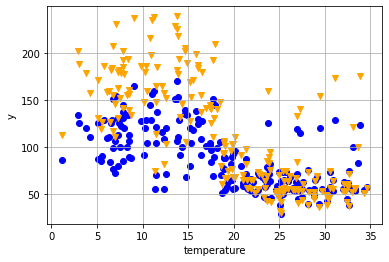

In [ ]:
#販売数と温度の関係を調べる
plt.scatter(train['temperature'], train['y'], color = 'blue', marker = 'o')#linestyle = 'None')
plt.scatter(train['temperature'], pred, color = 'orange', marker = 'v')#linestyle = 'None')

plt.ylabel('y')
plt.xlabel('temperature')

plt.grid(True)
plt.show()

#青：訓練データ
#オレンジ：予測データ

RMSE 36.583242330311606


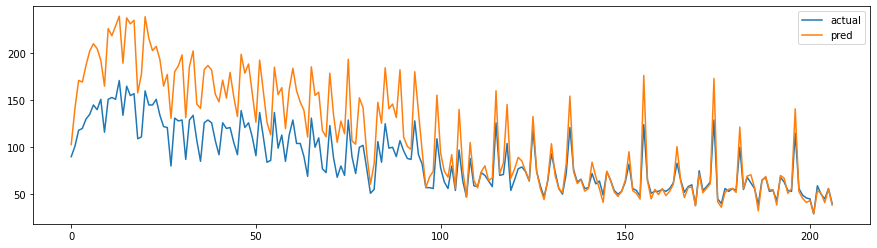

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
model2 = learning(train,y_train)
pred = model.predict(X_train) + model2.predict(train.iloc[:,train.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred})
# p.set_xlabel('days')
# p.set_ylabel('y')

p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred)**0.5)

#縦軸：売上個数
#横軸：日にち
#結果：気温による予測はそこそこ役に立つ

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
model2 = learning(train,y_train)
pred = model.predict(X_test) + model2.predict(test.iloc[:,test.columns.str.match("y")])

p = pd.DataFrame({"pred":pred})
# p.set_xlabel('days')
# p.set_ylabel('y')

p.plot(figsize=(15,4))
#print("RMSE",MSE(y_train,pred)**0.5)

#縦軸：売上個数
#横軸：日にち

## 天気と販売数の関係

In [ ]:
train.head()

In [ ]:
train['new_weather'] = 0
train.head()

In [ ]:
dic = {"快晴" : 1, "晴れ" : 2, "曇" : 3, "薄曇" : 4, "雨" : 5, "雪" : 6, "雷電" : 7}
def w(n):
  train.iloc[n, 9] = dic[train.iloc[n, 6]]
for i in range(207):
  w(i)
train.head(30)

In [ ]:
test['new_weather'] = 0


In [ ]:
test.head()

,datetime,week,soldout,name,kcal,weather,temperature,new_weather
0,2014-10-1,水,1,メンチカツ,420.0,雨,20.2,0
1,2014-10-2,木,0,バーベキューチキン,415.0,曇,23.9,0
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,晴れ,28.7,0
3,2014-10-6,月,1,麻婆春雨,400.0,雨,21.5,0
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,晴れ,22.1,0


In [ ]:
test['weather']

In [ ]:
def w_test(n):
  test.iloc[n, 7] = dic[test.iloc[n, 5]]
for i in range(40):
  w_test(i)
test.head(30)

,datetime,week,soldout,name,kcal,weather,temperature,new_weather
0,2014-10-1,水,1,メンチカツ,420.0,雨,20.2,5
1,2014-10-2,木,0,バーベキューチキン,415.0,曇,23.9,3
2,2014-10-3,金,0,豚肉のマスタード焼き,405.0,晴れ,28.7,2
3,2014-10-6,月,1,麻婆春雨,400.0,雨,21.5,5
4,2014-10-7,火,0,厚揚げ肉みそ炒め,430.0,晴れ,22.1,2
5,2014-10-8,水,0,完熟トマトのホットカレー,420.0,晴れ,23.3,2
6,2014-10-9,木,0,豚キムチ炒め,435.0,曇,22.5,3
7,2014-10-10,金,0,ポークカレー,420.0,薄曇,26.1,4
8,2014-10-14,火,0,若鶏梅肉包揚げ,408.0,快晴,26.8,1
9,2014-10-15,水,1,ミックスグリル,450.0,雨,15.6,5


In [ ]:
#カロリーを説明変数とする
X_train = train['new_weather']
#売上個数を目的変数とする
y_train = train['y']
#予測用データ
X_test = test['new_weather']

X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
X_train[:5]

model2 = LR()
model2.fit(X_train, y_train)
model2.coef_ #傾き

array([-5.51080325])

In [ ]:
model2.intercept_ #切片

101.13230808337569

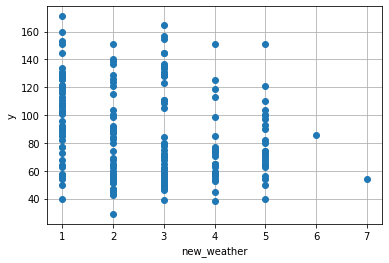

In [ ]:
#販売数と天気の関係を調べる
plt.plot(train['new_weather'], train['y'], 'o')
plt.ylabel('y')
plt.xlabel('new_weather')
plt.grid(True)

In [ ]:
model2.score(X_train, y_train) #検証

0.051823687937274765

In [ ]:
pred2 = model2.predict(X_test)
print(pred2)

[73.57829181 84.59989832 90.11070158 73.57829181 90.11070158 90.11070158
 84.59989832 79.08909507 95.62150483 73.57829181 90.11070158 95.62150483
 79.08909507 73.57829181 73.57829181 73.57829181 95.62150483 79.08909507
 95.62150483 95.62150483 90.11070158 84.59989832 90.11070158 84.59989832
 84.59989832 90.11070158 95.62150483 84.59989832 84.59989832 95.62150483
 95.62150483 79.08909507 95.62150483 95.62150483 84.59989832 95.62150483
 73.57829181 73.57829181 95.62150483 84.59989832]


## ランダムフォレスト

In [ ]:
def learning(train,y_train):
    model3 = RF(n_estimators=100,max_depth=4,random_state=777)
    pred2 = model2.predict(train["days"].values.reshape(-1,1))
    #print(pred)
    pred2_sub = y_train - pred2
    #print(pred_sub)
    model3.fit(train.iloc[:, train.columns.str.match("y")],pred2_sub)
    return model3

In [ ]:
print(pred2)

[73.57829181 84.59989832 90.11070158 73.57829181 90.11070158 90.11070158
 84.59989832 79.08909507 95.62150483 73.57829181 90.11070158 95.62150483
 79.08909507 73.57829181 73.57829181 73.57829181 95.62150483 79.08909507
 95.62150483 95.62150483 90.11070158 84.59989832 90.11070158 84.59989832
 84.59989832 90.11070158 95.62150483 84.59989832 84.59989832 95.62150483
 95.62150483 79.08909507 95.62150483 95.62150483 84.59989832 95.62150483
 73.57829181 73.57829181 95.62150483 84.59989832]


In [ ]:
print(y_train)

0       90
1      101
2      118
3      120
4      130
      ... 
202     59
203     50
204     45
205     56
206     40
Name: y, Length: 207, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor

#ランダムフォレストと勾配ブースティングのパラメータ設定
models = {
    'RandomForest':RF(random_state=0),
    'GradientBoost':GradientBoostingRegressor(random_state=0)
}

y_test = pred2
#モデル構築
scores = {}
for model_name, model in models.items():
  model.fit(X_train,y_train)
  scores[(model_name,'train_score')] = model.score(X_train, y_train)
  scores[(model_name,'test_score')] = model.score(X_test, y_test)

#結果を表示
pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,0.208512,0.104216
RandomForest,0.139942,0.103322


RMSE 496.8463766867109


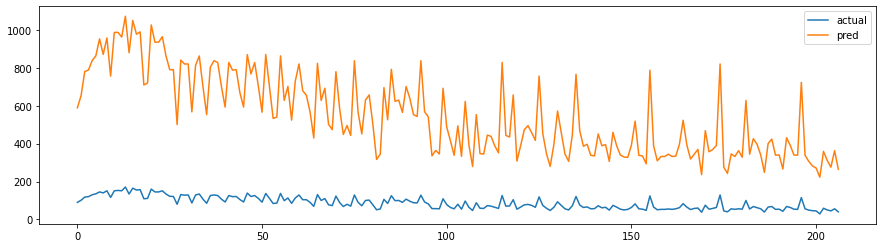

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
model3 = learning(train,y_train)
pred2 = model.predict(X_train) + model3.predict(train.iloc[:,train.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred2})
# p.set_xlabel('days')
# p.set_ylabel('y')

p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred2)**0.5)

#縦軸：売上個数
#横軸：日にち
#結果：天気による予測は効果的でない